In [2]:
target = 'TIC 413809436'

Please refer to Section 2 and 3 for using the fits file. 

### 1.2 Fit with the package `tglc`. (SKIP THIS IF YOU DOWNLOADED DATA FROM MAST)

First install `tglc` with [pip](https://pypi.org/project/tglc/) : `pip install tglc`. Require python version 3.8.0 or newer.

In [ ]:
import tglc
tglc.__version__

The version of this tutorial uses tglc version 0.6.0, please make sure your version is up-to-date. Let's start with fitting the first sector this star was observed in. Some of the output light curve of this tutorial is included in the tutorial folder for comparison. 

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tglc.quick_lc import tglc_lc

local_directory = f'{target}/'    # directory to save all files
os.makedirs(local_directory, exist_ok=True)
tglc_lc(target=target, 
        local_directory=local_directory, # directory to output everything
        size=90, # FFI cutsize. Recommand at least 50 or larger for better performance. Cannot exceed 99. 
                 # Downloading FFI might take longer (or even cause timeouterror) for larger sizes. 
        save_aper=True, # whether to save 5*5 pixels timeseries of the decontaminated images in fits file primary HDU
        limit_mag=15, # the TESS magnitude lower limit of stars to output
        get_all_lc=False, # whether to return all lcs in the region. If False, return the nearest star to the target coordinate
        first_sector_only=False, # whether to return only lcs from the sector this target was first observed. 
                                # If False, return all sectors of the target, but too many sectors could be slow to download.
        last_sector_only=True, # whether to return only lcs from the sector this target was last observed. 
        sector=None, # If first_sector_only = True or last_sector_only = True and type(sector) != int, return first or last sector.
                     # If first(last)_sector_only=False and sector = None, return all observed sectors
                     # If first(last)_sector_only=False and type(sector) == int, return only selected sector. 
                     # (Make sure only put observed sectors. All available sectors are printed in the sector table.)
        prior=None,  # If None, does not allow all field stars to float. SUGGESTED for first use. 
                     # If float (usually <1), allow field stars to float with a Gaussian prior with the mean 
                     # at the Gaia predicted value the width of the prior value multiplied on the Gaia predicted value.
        transient=None, # If generating light curve at an arbitrary RA and Dec, set this to [`name', `RA', `DEC'].
                        # Make sure target = 'RA Dec'
        )

Target: TIC 413809436
  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0012-2-4     12      2   4
tess-s0038-2-3     38      2   3
tess-s0065-2-3     65      2   3
Only processing the last sector the target is observed in: Sector 65.
Target Gaia: Gaia DR2 5886945685085166464
INFO: Query finished. [astroquery.utils.tap.core]
Found 131463 Gaia DR3 objects.
Found 6957 TIC objects.
INFO: Query finished. [astroquery.utils.tap.core]
Already in sector 65.


Fitting lc: 100%|███████████████████████████| 1/1 [00:04<00:00,  4.41s/it]


This could take a while to download depending on the cutsize. Once finished, you get the light curves you asked and can check the FFI cut and the effective PSF shape.

### 1.3 FFI cut and ePSF
Note the ePSF is twice oversampled in this plot. 

sector = 65


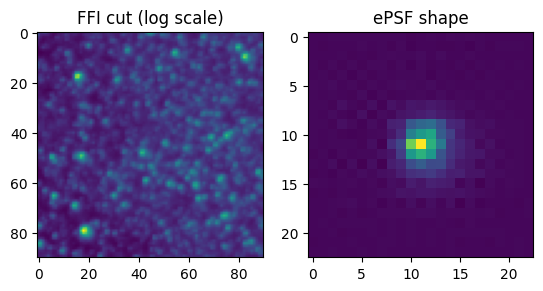

In [6]:
import pickle

sector = 65
with open(f'{local_directory}source/source_{target}_sector_{sector}.pkl', 'rb') as input_: # replace with each sector's .pkl file if you have more than the first sector
    source = pickle.load(input_)
    print(f'sector = {source.sector}')
epsf = np.load(f'{local_directory}epsf/epsf_{target}_sector_{sector}.npy')

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.log10(source.flux[0]))
ax1.set_title('FFI cut (log scale)')
ax2.imshow(epsf[0,:23**2].reshape(23,23))
ax2.set_title('ePSF shape')
plt.show()
# print(source.gaia[:5]) # all the gaia stars 
# print(source.tic[:5]) # TIC ID to Gaia DR2 conversion

### 1.4 Variability source identification plot

Already in sector 32.
Interquartile Range (IQR): 0.00098111166564549
Standard Deviation: 0.0007094899461212589


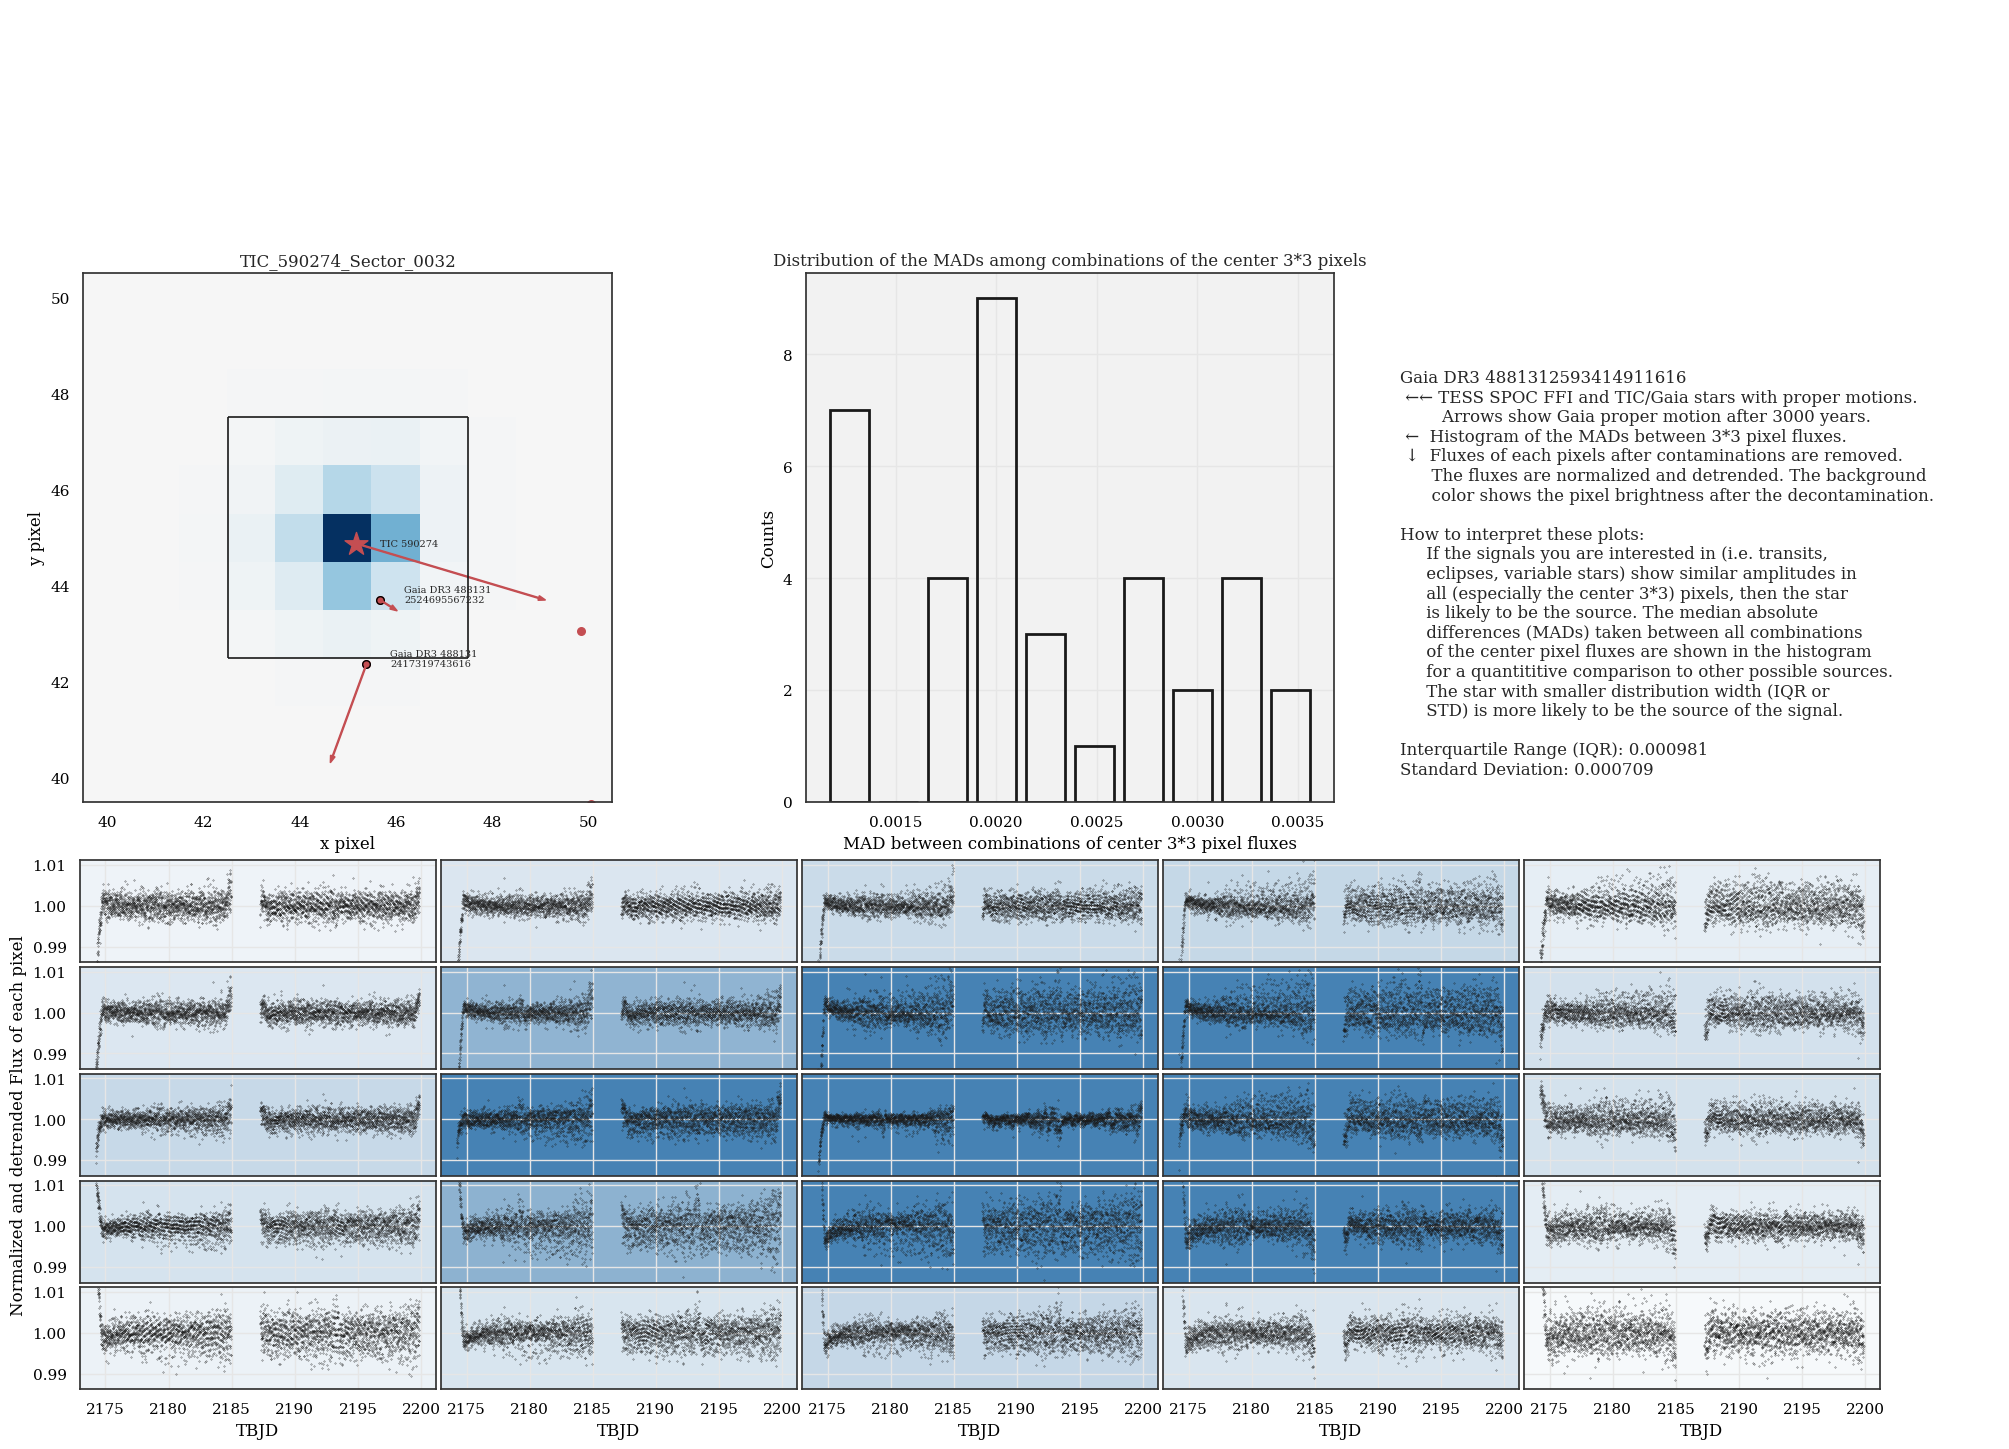

In [28]:
%matplotlib inline
from tglc.quick_lc import plot_contamination
plot_contamination(local_directory=local_directory,  # directory to output everything
                   gaia_dr3=4881312593414911616,  # Gaia DR3 ID for the target to analyze
                   ymin=None, # manually set ymin of pixel fluxes,
                   ymax=None, # manually set ymax of pixel fluxes,
                   # pm_years=3000 # determines the proper motion arrow length of equivalent years
                   )

If you would like to get all sectors of light curves for this target, you may run the following:

In [ ]:
tglc_lc(target=target, local_directory=local_directory, size=90, save_aper=True, limit_mag=15, 
        get_all_lc=False, first_sector_only=False, sector=None, prior=None)  

Target: TIC 413809436
  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0012-2-4     12      2   4
tess-s0038-2-3     38      2   3
tess-s0065-2-3     65      2   3
Processing all available sectors of the target.
################################################
Target Gaia: Gaia DR2 5886945685085166464
INFO: Query finished. [astroquery.utils.tap.core]
Found 131463 Gaia DR3 objects.
Found 6957 TIC objects.
INFO: Query finished. [astroquery.utils.tap.core]


# 2. Data structure

In [30]:
from astropy.io import fits
hdul = fits.open('TIC 413809436/lc/')
hdul.info()

Filename: TIC 590274/lc/hlsp_tglc_tess_ffi_gaiaid-4881312593414911616-s0032-cam2-ccd1_tess_v2_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      39   (5, 5, 3600)   float32   
  1  LIGHTCURVE    1 BinTableHDU     59   3600R x 9C   [D, E, E, E, E, E, J, I, I]   
  2                1 ImageHDU         8   (5, 5, 3)   float64   


The naming of tglc light curves follows the structure:
hlsp_tglc_tess_ffi_gaiaid-{Gaia DR3 ID}-s{sector}-cam{camera No.}-ccd{CCD No.}_tess_v1_llc.fits

Each light curve fits file has two HDUs: the Primary HDU is a 5\*5 pixels cut around the star (will be empty if you downloaded from MAST); the Second HDU contains the light curves. 

If you saved the decontaminated image (save_aper=True), you can access the 5\*5 pixels time series of decontaminted images. This is useful for making light curves with arbitrary apeture shapes. 

# 3. Exoplanet example
Below are the raw light curves of TOI-519 (TIC 218795833), which we produced above. It is known to host an exoplanet, and it is very faint (14.5 TESS mag).  Note: The following light curves are made with 150$*$150 FFIcut (These are/will be published on MAST). You may compare them to the light curves we made in Section 1 with 90$*$90 pixels. 

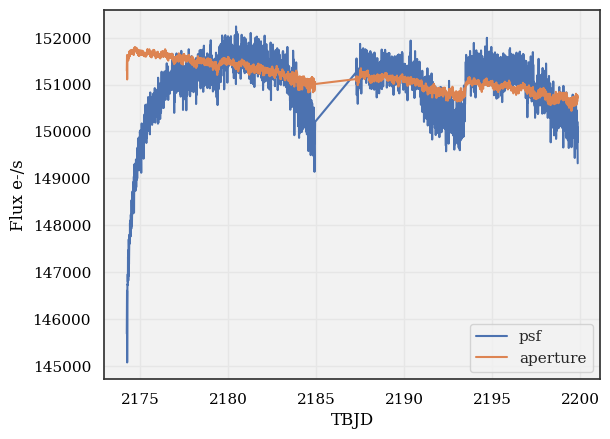

In [33]:
q = [a and b for a, b in zip(list(hdul[1].data['TESS_flags'] == 0),
                                list(hdul[1].data['TGLC_flags'] == 0))]
# filter out bad datapoints from both TESS FFI flags and TGLC flags

time = hdul[1].data['time'][q]
psf_flux = hdul[1].data['psf_flux'][q] # raw psf flux
psf_flux_err = hdul[1].header['PSF_ERR'] # raw psf flux error
aper_flux = hdul[1].data['aperture_flux'][q] # raw aper flux
aper_flux_err = hdul[1].header['APER_ERR'] # raw aper flux error
plt.errorbar(time, psf_flux, #psf_flux_err, 
             marker = '', label = 'psf')
plt.errorbar(time, aper_flux, #aper_flux_err, 
             marker = '', label = 'aperture')
plt.xlabel('TBJD')
plt.ylabel('Flux e-/s')
plt.legend()
plt.show()

Note that the two light curves have different median flux levels. This is because the raw aperture flux only sums a 3\*3 pixel region around the star, which is not 100\% of the flux from the star. We account for this as well as the low frequency trend in the calibrated light curves. 

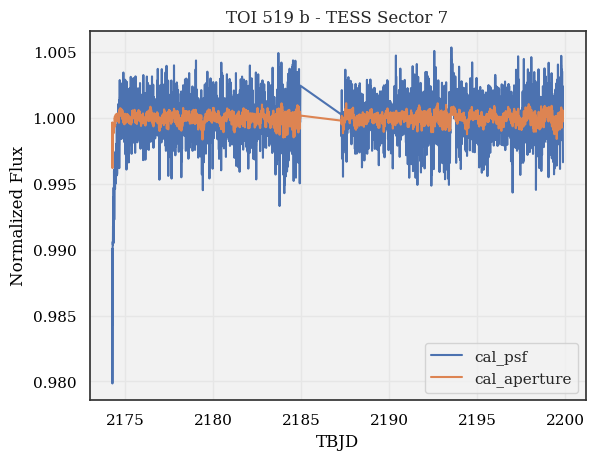

In [34]:
cal_psf_flux = hdul[1].data['cal_psf_flux'][q] # calibrated psf flux
cal_psf_flux_err = hdul[1].header['CPSF_ERR'] # calibrated psf flux error
cal_aper_flux = hdul[1].data['cal_aper_flux'][q] # calibrated aper flux
cal_aper_flux_err = hdul[1].header['CAPE_ERR'] # calibrated aper flux error
plt.errorbar(time, cal_psf_flux, #cal_psf_flux_err, 
             marker = '', label = 'cal_psf')
plt.errorbar(time, cal_aper_flux, #cal_aper_flux_err, 
             marker = '', label = 'cal_aperture')
plt.xlabel('TBJD')
plt.ylabel('Normalized Flux')
plt.legend()
plt.show()

We can also crossmatch different sectors of the same star. TOI-519 has been observed by TESS for four times until today. We will bin all sectors to 30-min for fair comparison. Be careful since the primary mission (1-26), 1st extended mission (27-55), and 2nd extended mission (56-) each have different cadence (1800s, 600s, and 200s).  Note: We only show the first three sectors, try the last sector (61) on your own!

In [35]:
hdul_s008 = fits.open('TIC 590274/lc/hlsp_tglc_tess_ffi_gaiaid-4881312593414911616-s0005-cam2-ccd1_tess_v2_llc.fits')
q_08 = [a and b for a, b in zip(list(hdul_s008[1].data['TESS_flags'] == 0),
                                list(hdul_s008[1].data['TGLC_flags'] == 0))]
time_08 = hdul_s008[1].data['time'][q_08]
cal_psf_flux_08 = hdul_s008[1].data['cal_psf_flux'][q_08] # calibrated psf flux
cal_psf_flux_err_08 = hdul_s008[1].header['CPSF_ERR'] # calibrated psf flux error

hdul_s034 = fits.open('TIC 590274/lc/hlsp_tglc_tess_ffi_gaiaid-4881312593414911616-s0032-cam2-ccd1_tess_v2_llc.fits')
q_34 = [a and b for a, b in zip(list(hdul_s034[1].data['TESS_flags'] == 0),
                                list(hdul_s034[1].data['TGLC_flags'] == 0))]
time_34 = hdul_s034[1].data['time'][q_34]
time_34 = np.mean(time_34[:len(time_34) // 3 * 3].reshape(-1, 3), axis=1)
cal_psf_flux_34 = hdul_s034[1].data['cal_psf_flux'][q_34] # calibrated psf flux
cal_psf_flux_34 = np.mean(cal_psf_flux_34[:len(cal_psf_flux_34) // 3 * 3].reshape(-1, 3), axis=1)
cal_psf_flux_err_34 = hdul_s034[1].header['CPSF_ERR'] # calibrated psf flux error

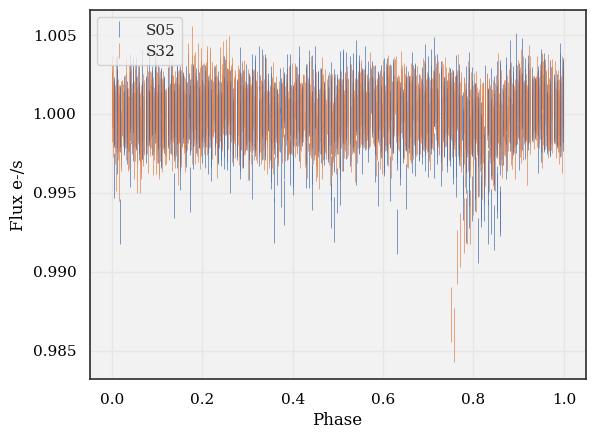

In [39]:
period = 3
plt.errorbar(time_08 % period / period, cal_psf_flux_08, cal_psf_flux_err_08, marker = '', lw=0.5, ls = '', label = 'S05')
plt.errorbar(time_34 % period / period, cal_psf_flux_34, cal_psf_flux_err_34, marker = '', lw=0.5, ls = '', label = 'S32')
# plt.title('TOI 519 b - Calibrated PSF flux')
plt.xlabel('Phase')
plt.ylabel('Flux e-/s')
plt.legend()
plt.show()

The two flags take out the majority of bad datapoints, although several outliers remain. We can see a consistant transit depth among three sectors (correct dilution), an indication of the robustness of tglc.